## Imports

In [1]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [2]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Configuration

In [3]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # flower labels (folder names in the data)

## Read images and labels [WORK WAS REQUIRED HERE]
1. Use `fileset=`[`tf.data.Dataset.list_files`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) to scan the data folder
1. Iterate through the dataset of filenames: `for filename in fileset:...` . 
 * Does it work ? Yes, but if you print the filename you get Tensors containing strings.
 * To display the string only, you can use filename.numpy(). This works on any Tensorflow tensor.
 * tip: to limit the size of the dataset for display, you can use [`Dataset.take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Like this: `for data in dataset.take(10): ....`
1. Use [`tf.data.Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to decode the JPEG files. You will find useful TF code snippets below.
 * Iterate on the image dataset. You can use .numpy().shape to only see the data sizes.
  * Are all images of the same size ?
1. Now create a training dataset: you have images but you also need labels:
 *  the labels (flower names) are the directory names. You will find useful TF code snippets below for parsing them.
 * If you do "`return image, label`" in the decoding function, you will have a Dataset of pairs (image, label).
1. You can see the flowers and their labels with the `display_9_images_from_dataset` function. It expects the Dataset to have `(image, label)` elements.

Pattern matches 3670 images.
gs://flowers-public/daisy/14272874304_47c0a46f5a.jpg
gs://flowers-public/dandelion/4574736702_b15ecf97d0_m.jpg
gs://flowers-public/sunflowers/5032376020_2ed312306c.jpg
gs://flowers-public/sunflowers/2575272111_f04d79b9af_n.jpg
gs://flowers-public/dandelion/5607983792_f8b8766ff7.jpg
gs://flowers-public/sunflowers/5139971615_434ff8ed8b_n.jpg
gs://flowers-public/sunflowers/21518663809_3d69f5b995_n.jpg
gs://flowers-public/sunflowers/6199086734_b7ddc65816_m.jpg
gs://flowers-public/dandelion/4691257171_23a29aaa33_n.jpg
gs://flowers-public/tulips/13976191172_6f23a0b313.jpg
(309, 500, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(325, 500, 3)
(200, 320, 3)
(213, 320, 3)
(351, 500, 3)
(240, 180, 3) dandelion
(213, 320, 3) daisy
(239, 240, 3) roses
(240, 180, 3) tulips
(343, 500, 3) sunflowers
(287, 320, 3) roses
(333, 500, 3) dandelion
(212, 320, 3) tulips
(375, 500, 3) daisy
(333, 500, 3) tulips


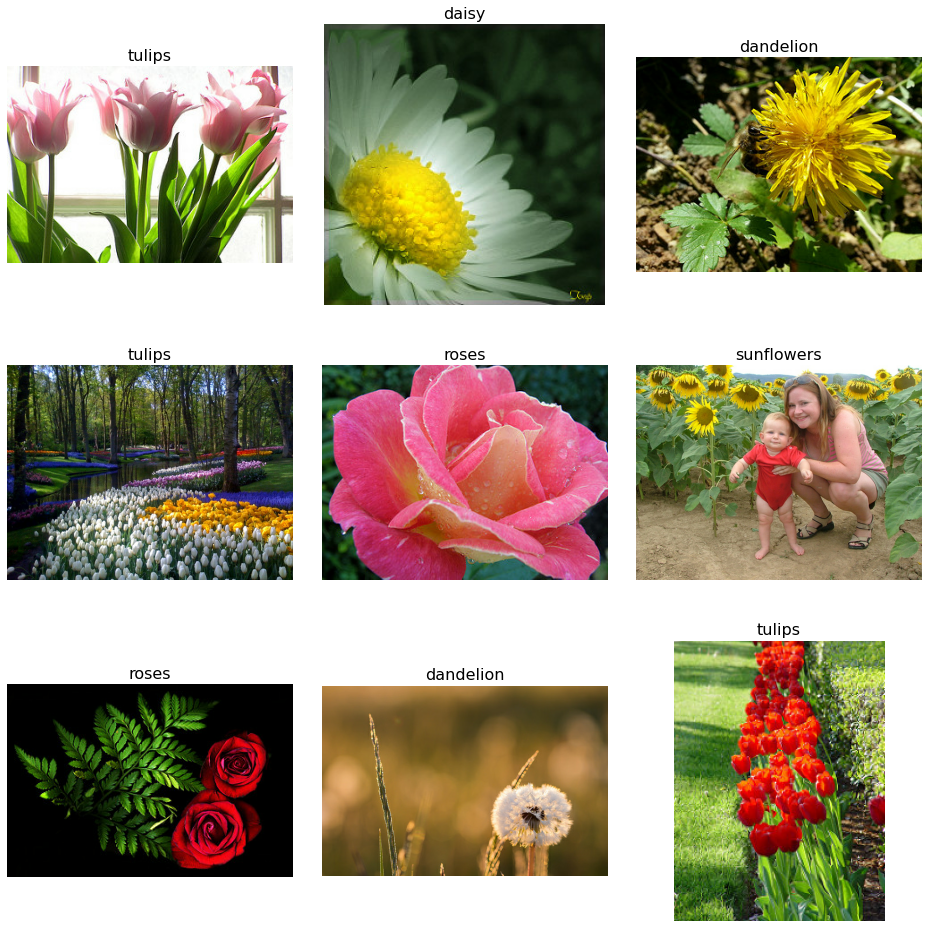

In [4]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
print("Pattern matches {} images.".format(nb_images))

### QUESTIONS 1. and 2.
filenames_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
for filename in filenames_dataset.take(10):
  print(filename.numpy().decode('utf-8'))
  
### QUESTION 3.

# copy-pasted from "useful code snippets" below
def decode_jpeg(filename):
  bits = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  return image

image_dataset = filenames_dataset.map(decode_jpeg)
for image in image_dataset.take(10):
  print(image.numpy().shape)
  
### QUESTION 4.

# copy-pasted from "useful code snippets" below
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

dataset = filenames_dataset.map(decode_jpeg_and_label)
for image, label in dataset.take(10):
  print(image.numpy().shape, label.numpy().decode('utf-8'))

  ### QUESTION 5.
display_9_images_from_dataset(dataset)

## Useful code snippets

### Decode a JPEG in Tensorflow

In [ ]:
def decode_jpeg(filename):
  bits = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  return image

### Decode a JPEG and extract folder name in Tensorflow

In [ ]:
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits)
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
